# W4 practical

## 📝 Learning goals of practical

- You can describe how GO enrichment is applied and to what kinds of data

- You can list how GO enrichment can be used to propose new experiments

## Data setup and inspection

Lets load some of the stuff from last week

In [ ]:
import sys
if "google.colab" in sys.modules:
    %pip install git+https://github.com/CropXR/EduXR.git
else:
    %load_ext autoreload
    %autoreload 2

In [ ]:
# %pip install -q fastcluster goatools

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from goatools.obo_parser import GODag
from goatools.go_enrichment import GOEnrichmentStudy
from goatools.anno.gaf_reader import GafReader
from goatools.evidence_codes import EvidenceCodes

from goatools.godag_plot import plot_gos
from IPython.display import Image, display
import tempfile



In [ ]:
## Download all necessary files

# Expression data we looked at in week 2
!wget https://raw.githubusercontent.com/CropXR/EduXR/refs/heads/main/data/biotic_transcriptomics.txt
# Gene Ontology annotations
!wget https://raw.githubusercontent.com/CropXR/EduXR/refs/heads/main/data/go-basic.obo
!wget https://raw.githubusercontent.com/CropXR/EduXR/refs/heads/main/data/tair.gaf

### ❓Questions

- Let's look at the clustering again. What number of clusters would you say is agreeable? You can change both the number of clusters and the linkage that is used. (E.g. `'complete'`, `'average'`, or `'single'`)

In [5]:
def read_and_cluster_expression_data(in_path, n_clusters, linkage_method):
    # Hierarchical clustering
    df = pd.read_csv(in_path, sep='\t', header=[0], index_col=0, skiprows=[1,2])
    df.index = [i.split(' ')[1].upper() for i in df.index.tolist()]
    plt.figure(figsize=(10, 10))
    Z = linkage(df, method=linkage_method, metric='correlation')
    df['cluster'] = fcluster(Z, t=n_clusters, criterion='maxclust')

    # Map clusters to colours for heatmap
    palette = sns.color_palette("tab10", n_clusters)
    row_colors = [palette[i-1] for i in df['cluster'] ]

    # %% Clustermap
    g = sns.clustermap(
        df.drop(columns='cluster'),
        row_linkage=Z,
        metric="correlation",
        cmap="vlag",
        vmin=-2, vmax=2,
        row_colors=row_colors,
        figsize=(10,10)
    )
    g.ax_heatmap.set_yticks([])
    g.ax_heatmap.set_yticklabels([])
    plt.show()
    cluster_counts = df.groupby('cluster').size()

    # Map cluster numbers to the same colours
    cluster_colors = [palette[i-1] for i in cluster_counts.index]

    cluster_counts.plot(
        kind='bar',
        title='Number of genes per cluster',
        color=cluster_colors
    )
    plt.show()
    return df


def show_genes_per_cluster(df):
    for i, df in df.groupby('cluster'):
        print(i, df.index.tolist())

<Figure size 1000x1000 with 0 Axes>

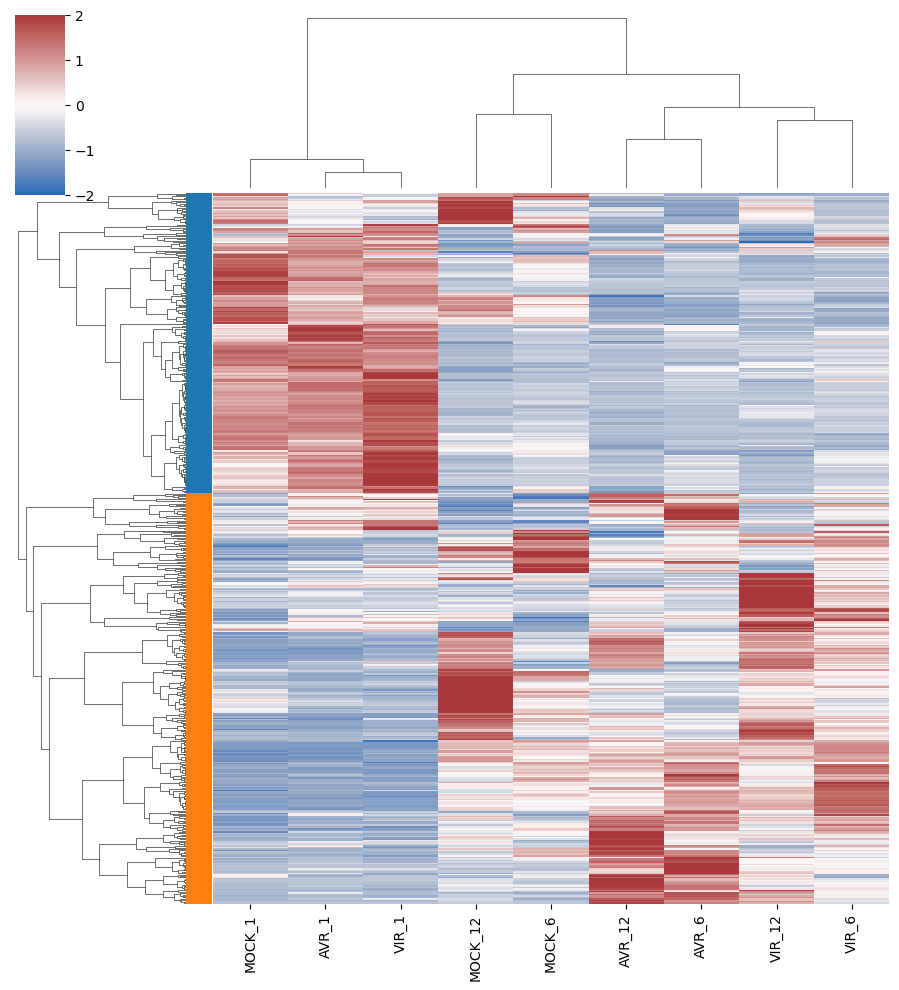

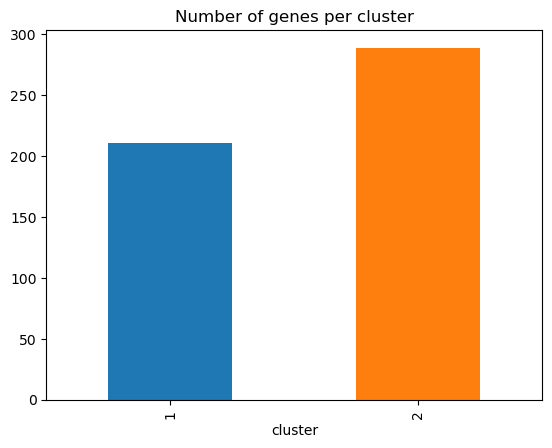

In [7]:
clustered_df = read_and_cluster_expression_data('biotic_transcriptomics.txt', n_clusters=2, linkage_method='complete')

Now we can see the gene IDs in each module:

In [ ]:
show_genes_per_cluster(clustered_df)

Annotation data is available for Arabidopsis genes (and those of other species). Pick one of these genes from the list above, and let's see what's known about them.

Since GO is an 'ontology', we can plot the hierarchy of the annotations as well.

In [ ]:
godag = GODag("go-basic.obo")  
tair_gaf = GafReader("tair.gaf")



In [ ]:
def show_annotations_of_gene(gene_id: str, tair_gaf: GafReader, godag: GODag):
    annotations = tair_gaf.get_id2gos('BP')  
    nts = tair_gaf.associations
    assert gene_id in annotations, f"Gene {gene_id} not found in annotations."

    # Print hierarchy
    with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmp:
        filename = tmp.name

        plot_gos(filename, 
            list(annotations[gene_id]), # Source GO ids
            godag)

        # Display it in the notebook
        display(Image(filename))

    for nt in nts:
        if nt.DB_ID == gene_id and nt.GO_ID in annotations[gene_id]:
            print(f' {nt.GO_ID}, Source: {nt.Assigned_By}, {nt.Evidence_Code}, {EvidenceCodes.code2nt[nt.Evidence_Code].name}')

def print_all_evidence_codes():
    for i, j in EvidenceCodes.code2nt.items():
        print(i, j.name)

Lets inspect the annotations of an example gene. 

In [ ]:
show_annotations_of_gene("YOUR_GENE_NAME_HERE", tair_gaf, godag)

In [ ]:
print_all_evidence_codes()

### ❓Questions

- Which of these evidence codes do you think are most reliable? And which are least reliable?

- What are disadvantages of looking only at single genes? Do you think all the GO terms you find for your gene make sense?

- What is the goal of GO enrichment analysis?

Now let's do an enrichment study for all the clusters.

In [ ]:
def perform_go_enrichment(clustered_df, cluster_id, tair_gaf, godag, fdr_cutoff=0.05):
    goeaobj = GOEnrichmentStudy(
        clustered_df.index.tolist(),  
        tair_gaf.get_id2gos('BP'),
        godag,
        methods=['fdr_bh'],
        )
    results = goeaobj.run_study(clustered_df.groupby('cluster').groups[cluster_id].tolist(), prt=None)
    rows = []
    for ntd in results:
        if ntd.p_fdr_bh < fdr_cutoff:
            rows.append({
                'NS': ntd.NS,
                'GO': ntd.GO,
                'Name': ntd.name,
                'e/p': ntd.enrichment,
                'pval_uncorr': ntd.p_uncorrected,
                'BH': ntd.p_fdr_bh,
                'study_ratio': f"{ntd.ratio_in_study[0]}/{ntd.ratio_in_study[1]}",
                'pop_ratio': f"{ntd.ratio_in_pop[0]}/{ntd.ratio_in_pop[1]}"
            })

    df_results = pd.DataFrame(rows)
    df_results = df_results.sort_values(['BH'])
    
    # Make a temporary file
    with tempfile.NamedTemporaryFile(suffix=".png", delete=True) as tmp:
        filename = tmp.name

        plot_gos(filename, 
            df_results['GO'], # Source GO ids
            godag, 
            goea_results=results)

        # Display it in the notebook
        display(Image(filename))

    return df_results


In [ ]:
perform_go_enrichment()

GO terms colored by P-value:
- pval < 0.005 (light red)
- pval < 0.01 (light orange)
- pval < 0.05 (yellow)
- pval > 0.05 (grey) Study terms that are not statistically significant

Interestingly, these GO terms can also be the result of machine learning models (check the evidence codes).